# Импорты

In [30]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

from typing import Any, Callable, Dict, Final

from rich.console import Console
from rich.table import Table

# 2048

In [21]:
class Game2048Env(gym.Env):
    LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3

    def __init__(self, width=4, height=4, seed=None):
        super().__init__()
        self.width = width
        self.height = height
        self.score = 0
        self.observation_space = spaces.Box(
            low=0.0, high=20.0, shape=(width * height,), dtype=np.float32,
        )
        self.action_space = spaces.Discrete(4)
        self.rng = np.random.default_rng(seed)
        self.reset()

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.board = np.zeros((self.height, self.width), dtype=np.int64)
        self.score = 0
        self._place_random_tiles(2)
        return self._get_obs(), {}

    def step(self, action):
        board_before = self.board.copy()

        rotated = np.rot90(self.board, k=action)
        merge_reward, updated_rotated = self._slide_left_and_merge(rotated)
        self.board = np.rot90(updated_rotated, k=4 - action)

        self._place_random_tiles(1)
        self.score += merge_reward
        reward = merge_reward
        terminated = self._is_done()

        if np.array_equal(board_before, self.board):
            terminated = True

        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        safe_board = np.where(self.board == 0, 1, self.board)
        log_board = np.log2(safe_board).astype(np.float32)
        return log_board.flatten()

    def _place_random_tiles(self, count):
        empty = np.argwhere(self.board == 0)
        if len(empty) == 0:
            return
        n = min(count, len(empty))
        indices = self.rng.choice(len(empty), size=n, replace=False)
        tiles = self.rng.choice([2, 4], size=n, p=[0.9, 0.1])
        for tile, pos in zip(tiles, empty[indices]):
            self.board[tuple(pos)] = tile

    def _slide_left_and_merge(self, board):
        total_score = 0.0
        result = []
        for row in board:
            nonzeros = row[row > 0]
            merged = []
            i = 0
            while i < len(nonzeros):
                if i + 1 < len(nonzeros) and nonzeros[i] == nonzeros[i + 1]:
                    new_tile = nonzeros[i] * 2
                    merged.append(new_tile)
                    total_score += np.log2(new_tile)
                    i += 2
                else:
                    merged.append(nonzeros[i])
                    i += 1
            merged.extend([0] * (self.width - len(merged)))
            result.append(merged)
        return total_score, np.array(result, dtype=np.int64)

    def _is_done(self):
        if np.any(self.board == 0):
            return False
        for action in range(4):
            rotated = np.rot90(self.board, k=action)
            _, updated = self._slide_left_and_merge(rotated)
            if not np.array_equal(rotated, updated):
                return False
        return True

    def max_tile(self):
        return int(self.board.max())

    def render(self):
        print(self.board)

# Проверка среды

In [22]:
env_test = Game2048Env()
check_env(env_test, warn=True)

# Вспомогательный функции

In [31]:
def evaluate_agent(
    agent: Any,
    env: gym.Env,
    n_episodes: int = 5,
    max_steps: int = 2_000,
    seed: int | None = None,
    use_tqdm: bool = False,
) -> Dict[str, float]:
    if use_tqdm:
        from tqdm import trange
        episode_range = trange(n_episodes, desc="Evaluating")
    else:
        episode_range = range(n_episodes)

    max_tiles = []
    scores = []
    lengths = []

    for ep in episode_range:
        if seed is not None:
            obs, _ = env.reset(seed=seed + ep)
        else:
            obs, _ = env.reset()

        steps = 0
        while steps < max_steps:
            if hasattr(agent, 'predict'):
                action, _ = agent.predict(obs, deterministic=True)
            elif callable(agent):
                action = agent(obs)
                if hasattr(action, 'item'):
                    action = action.item()
                elif isinstance(action, np.ndarray):
                    action = int(action[0]) if action.ndim > 0 else int(action)
                else:
                    action = int(action)
            else:
                raise ValueError('Агент должен быть доступен для вызова или иметь метод прогнозирования')

            obs, _, terminated, truncated, _ = env.step(action)

            steps += 1

            if terminated or truncated:
                break

        max_tiles.append(env.max_tile())
        scores.append(env.score)
        lengths.append(steps)

    max_tiles = np.asarray(max_tiles)
    scores= np.asarray(scores)
    lengths = np.asarray(lengths)

    return {
        'avg_score': float(scores.mean()),
        'max_tile_achieved': int(max_tiles.max()),
        'avg_max_tile': float(max_tiles.mean()),
        'median_max_tile': float(np.median(max_tiles)),
        'min_max_tile': int(max_tiles.min()),
        'std_max_tile': float(max_tiles.std()),

        'pct_2048_or_more': float((max_tiles >= 2048).mean() * 100),

        'avg_episode_length': float(lengths.mean()),
        'max_episode_length': int(lengths.max()),
        'min_episode_length': int(lengths.min()),
    }

In [32]:
def print_evaluation_results_rich(results: dict, title: str = 'Результаты'):
    console = Console()

    # Словарь для красивых названий (можно расширять)
    pretty_names = {
        'avg_score': 'Средний счёт',
        'max_tile_achieved': 'Макс. плитка',
        'avg_max_tile': 'Средняя макс. плитка',
        'median_max_tile': 'Медиана макс. плитки',
        'min_max_of_episodes': 'Мин. макс. плитка',
        'min_max_tile': 'Мин. макс. плитка',
        'std_max_tile': 'Стд. откл. макс. плитки',
        'pct_2048_or_more': 'Доля ≥2048 (%)',
        'avg_episode_length': 'Средняя длина игры',
        'max_episode_length': 'Макс. длина игры',
        'min_episode_length': 'Мин. длина игры',
    }

    table = Table(title=f'{title}', title_style='bold green', show_lines=True)
    table.add_column('Метрика', style='cyan', justify='left')
    table.add_column('Значение', style='magenta', justify='right')

    for key, value in results.items():
        # Преобразуем ключ в читаемое имя
        label = pretty_names.get(key, key.replace('_', ' ').capitalize())

        # Форматируем значение
        if isinstance(value, float):
            if 'pct' in key or '%' in label:
                formatted = f'{value:.1f}%'
            else:
                formatted = f'{value:.2f}'
        else:
            formatted = str(value)

        table.add_row(label, formatted)

    console.print(table)

In [33]:
def make_env():
    return Game2048Env()

TOTAL_TIMESTEPS: Final[int] = 10_000_000
N_EPISODES: Final[int] = 10

# DQN

In [35]:
vec_env = make_vec_env(make_env, n_envs=4)
dqn_model = DQN(
    'MlpPolicy',
    vec_env,
    buffer_size=100_000,
    learning_starts=10_000,
    batch_size=128,
)

dqn_model.learn(total_timesteps=TOTAL_TIMESTEPS)

env = Game2048Env()
dqn_results = evaluate_agent(dqn_model, env, n_episodes=N_EPISODES)
print_evaluation_results_rich(dqn_results, 'DQN результаты')

            DQN результаты            
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Метрика                 ┃ Значение ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Средний счёт            │   287.80 │
├─────────────────────────┼──────────┤
│ Макс. плитка            │      128 │
├─────────────────────────┼──────────┤
│ Средняя макс. плитка    │    89.60 │
├─────────────────────────┼──────────┤
│ Медиана макс. плитки    │    64.00 │
├─────────────────────────┼──────────┤
│ Мин. макс. плитка       │       64 │
├─────────────────────────┼──────────┤
│ Стд. откл. макс. плитки │    31.35 │
├─────────────────────────┼──────────┤
│ Доля ≥2048 (%)          │     0.0% │
├─────────────────────────┼──────────┤
│ Средняя длина игры      │   116.30 │
├─────────────────────────┼──────────┤
│ Макс. длина игры        │      164 │
├─────────────────────────┼──────────┤
│ Мин. длина игры         │       72 │
└─────────────────────────┴──────────┘

# PPO

In [44]:
vec_env_ppo = make_vec_env(make_env, n_envs=4)
ppo_model = PPO(
    'MlpPolicy',
    vec_env_ppo,
    n_steps=4096,
    batch_size=128,
)
ppo_model.learn(total_timesteps=TOTAL_TIMESTEPS)

env = Game2048Env()
ppo_results = evaluate_agent(ppo_model, env, n_episodes=N_EPISODES)
print_evaluation_results_rich(ppo_results, 'PPO результаты')

            PPO результаты            
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Метрика                 ┃ Значение ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Средний счёт            │   227.20 │
├─────────────────────────┼──────────┤
│ Макс. плитка            │      256 │
├─────────────────────────┼──────────┤
│ Средняя макс. плитка    │    76.80 │
├─────────────────────────┼──────────┤
│ Медиана макс. плитки    │    64.00 │
├─────────────────────────┼──────────┤
│ Мин. макс. плитка       │       32 │
├─────────────────────────┼──────────┤
│ Стд. откл. макс. плитки │    65.89 │
├─────────────────────────┼──────────┤
│ Доля ≥2048 (%)          │     0.0% │
├─────────────────────────┼──────────┤
│ Средняя длина игры      │    96.30 │
├─────────────────────────┼──────────┤
│ Макс. длина игры        │      217 │
├─────────────────────────┼──────────┤
│ Мин. длина игры         │       42 │
└─────────────────────────┴──────────┘

# Случайный агент

In [43]:
def random_agent(obs):
    return np.random.randint(0, 4)

rand_results = evaluate_agent(random_agent, env, n_episodes=N_EPISODES)
print_evaluation_results_rich(rand_results, 'Случайный агент')

           Случайный агент            
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Метрика                 ┃ Значение ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Средний счёт            │   143.10 │
├─────────────────────────┼──────────┤
│ Макс. плитка            │       64 │
├─────────────────────────┼──────────┤
│ Средняя макс. плитка    │    51.20 │
├─────────────────────────┼──────────┤
│ Медиана макс. плитки    │    64.00 │
├─────────────────────────┼──────────┤
│ Мин. макс. плитка       │       32 │
├─────────────────────────┼──────────┤
│ Стд. откл. макс. плитки │    15.68 │
├─────────────────────────┼──────────┤
│ Доля ≥2048 (%)          │     0.0% │
├─────────────────────────┼──────────┤
│ Средняя длина игры      │    67.80 │
├─────────────────────────┼──────────┤
│ Макс. длина игры        │       87 │
├─────────────────────────┼──────────┤
│ Мин. длина игры         │       45 │
└─────────────────────────┴──────────┘

# Сводная таблица

In [ ]:
rand_results = {**rand_results, 'agent': 'Random'}
dqn_results = {**dqn_results, 'agent': 'DQN'}
ppo_results = {**ppo_results, 'agent': 'PPO'}

df = pd.DataFrame([rand_results, dqn_results, ppo_results])
df.set_index('agent', inplace=True)
df = df.loc[['Random', 'DQN', 'PPO']]
df.round(1)

,avg_score,max_tile_achieved,avg_max_tile,median_max_tile,min_max_tile,std_max_tile,pct_2048_or_more,avg_episode_length,max_episode_length,min_episode_length
agent,,,,,,,,,,
Random,143.1,64,51.2,64.0,32,15.7,0.0,67.8,87,45
DQN,287.8,128,89.6,64.0,64,31.4,0.0,116.3,164,72
PPO,227.2,256,76.8,64.0,32,65.9,0.0,96.3,217,42


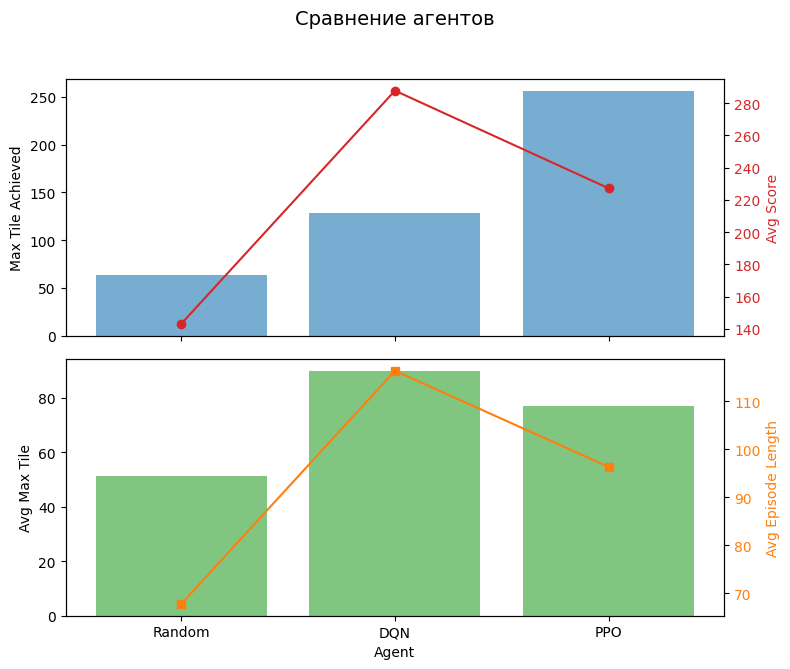

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

color1 = 'tab:blue'
ax1.set_ylabel('Max Tile Achieved')
bars1 = ax1.bar(df.index, df['max_tile_achieved'], color=color1, alpha=0.6, label='Max Tile')
ax1.tick_params(axis='y')

color2 = 'tab:red'
ax1_2 = ax1.twinx()
ax1_2.set_ylabel('Avg Score', color=color2)
line1 = ax1_2.plot(df.index, df['avg_score'], color=color2, marker='o', label='Avg Score')
ax1_2.tick_params(axis='y', labelcolor=color2)


color3 = 'tab:green'
ax2.set_ylabel('Avg Max Tile')
bars2 = ax2.bar(df.index, df['avg_max_tile'], color=color3, alpha=0.6, label='Avg Max Tile')
ax2.tick_params(axis='y')

color4 = 'tab:orange'
ax2_2 = ax2.twinx()
ax2_2.set_ylabel('Avg Episode Length', color=color4)
line2 = ax2_2.plot(df.index, df['avg_episode_length'], color=color4, marker='s', label='Avg Length')
ax2_2.tick_params(axis='y', labelcolor=color4)

ax2.set_xlabel('Agent')

plt.suptitle('Сравнение агентов', fontsize=14)
fig.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()